Let's develop a comprehensive analysis of the cnc_machine dataset to explore energy usage patterns and their correlation with CNC machine performance and productivity.
Considering that each CNC machine occupies  a distinct room of identical dimensions, with each room having the same n7umbers of walls in contact with the outside, my objective is to uncover insights that will help us to identify opportunities for developinmg predictive energy consumption models based on enviroment sensors.
In this project I will evaluate the feasability of developing a predictive model tailored to estimate the 10- minute average energy consumption of the factory by utilizing data obtained from sensors within the preceding 1 to 4 hours.

In [2]:
import numpy as np
import pandas as pd

import os

from pathlib import Path
from tqdm.autonotebook import tqdm
import statsmodels.api as sm
import warnings
import random
from IPython.display import display, HTML
np.random.seed(42)
random.seed(42)
tqdm.pandas()
import statsmodels.tsa.holtwinters as ets

In [3]:
df = pd.read_csv('C:/Users/User/Desktop/factory_20240131.csv', delimiter='\t')
df.head(30)

,time_batch,cnc_average_kw,work_stations_average_kw,temp_CNC_1,humidity_CNC_1,temp_CNC_2,humidity_CNC_2,temp_CNC_3,humidity_CNC_3,temp_CNC_4,...,temp_CNC_9,humidity_CNC_9,temp_outside,press_mm_hg_outside,humidity_outside,windspeed_outside,visibility_outside,dewpoint_outside,temp_CNC_10,humidity_CNC_10
0,11-01-2016 17:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.530000,6.60,733.500000,92.000000,7.000000,63.000000,5.30,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.48,733.600000,92.000000,6.666667,59.166667,5.20,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.500000,6.37,733.700000,92.000000,6.333333,55.333333,5.10,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.25,733.800000,92.000000,6.000000,51.500000,5.00,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.13,733.900000,92.000000,5.666667,47.666667,4.90,10.084097,10.084097
5,11-01-2016 17:50,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,17.000000,45.290000,6.02,734.000000,92.000000,5.333333,43.833333,4.80,44.919484,44.919484
6,11-01-2016 18:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,...,17.000000,45.290000,5.90,734.100000,92.000000,5.000000,40.000000,4.70,47.233763,47.233763
7,11-01-2016 18:10,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,17.000000,45.290000,5.92,734.166667,91.833333,5.166667,40.000000,4.68,33.039890,33.039890
8,11-01-2016 18:20,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,17.000000,45.290000,5.93,734.233333,91.666667,5.333333,40.000000,4.67,31.455702,31.455702
9,11-01-2016 18:30,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,17.000000,45.290000,5.95,734.300000,91.500000,5.500000,40.000000,4.65,3.089314,3.089314


1. PREPROCESSING
In the preprocessing phase I will set the time variable as a datetime format and assess if there are missing values (and eventually treat them) and outliers

In [4]:
#checking the format of the variables
df.dtypes

time_batch                   object
cnc_average_kw                int64
work_stations_average_kw      int64
temp_CNC_1                  float64
humidity_CNC_1              float64
temp_CNC_2                  float64
humidity_CNC_2              float64
temp_CNC_3                  float64
humidity_CNC_3              float64
temp_CNC_4                  float64
humidity_CNC_4              float64
temp_CNC_5                  float64
humidity_CNC_5              float64
temp_CNC_6                  float64
humidity_CNC_6              float64
temp_CNC_7                  float64
humidity_CNC_7              float64
temp_CNC_8                  float64
humidity_CNC_8              float64
temp_CNC_9                  float64
humidity_CNC_9              float64
temp_outside                float64
press_mm_hg_outside         float64
humidity_outside            float64
windspeed_outside           float64
visibility_outside          float64
dewpoint_outside            float64
temp_CNC_10                 

In [5]:
#setting time variable as a datetime format
df['time_batch'] = pd.to_datetime(df['time_batch'], format='%d-%m-%Y %H:%M') 
df.head()

,time_batch,cnc_average_kw,work_stations_average_kw,temp_CNC_1,humidity_CNC_1,temp_CNC_2,humidity_CNC_2,temp_CNC_3,humidity_CNC_3,temp_CNC_4,...,temp_CNC_9,humidity_CNC_9,temp_outside,press_mm_hg_outside,humidity_outside,windspeed_outside,visibility_outside,dewpoint_outside,temp_CNC_10,humidity_CNC_10
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
#controlling the format of the time variable
df['time_batch'].dtypes

dtype('<M8[ns]')

In [7]:
df.set_index('time_batch')

,cnc_average_kw,work_stations_average_kw,temp_CNC_1,humidity_CNC_1,temp_CNC_2,humidity_CNC_2,temp_CNC_3,humidity_CNC_3,temp_CNC_4,humidity_CNC_4,...,temp_CNC_9,humidity_CNC_9,temp_outside,press_mm_hg_outside,humidity_outside,windspeed_outside,visibility_outside,dewpoint_outside,temp_CNC_10,humidity_CNC_10
time_batch,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.60,733.5,92.000000,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.48,733.6,92.000000,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.37,733.7,92.000000,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.25,733.8,92.000000,6.000000,51.500000,5.0,45.410390,45.410390
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.13,733.9,92.000000,5.666667,47.666667,4.9,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.70,755.2,55.666667,3.333333,23.666667,13.3,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.60,755.2,56.000000,3.500000,24.500000,13.3,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.50,755.2,56.333333,3.666667,25.333333,13.3,29.199117,29.199117


Assessing if there are any missing values

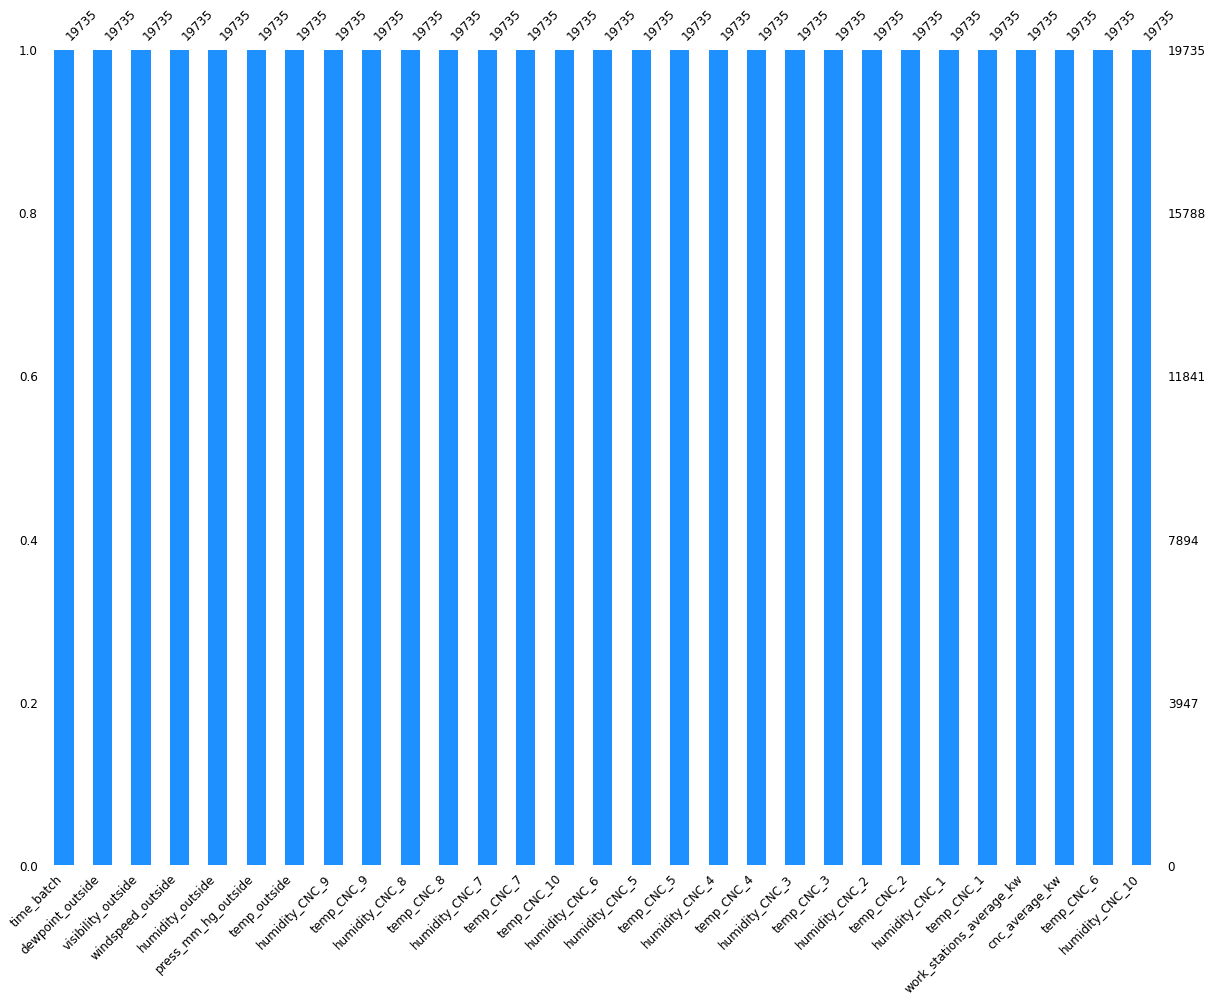

In [8]:
import missingno as msno
msno.bar(df, color="dodgerblue", sort="ascending", figsize=(20,15), fontsize=12);

As we can see from the plot, there aren't missing values, so we can proceed controlling outliers

In [9]:
#defining quantiles
Q1 = df['cnc_average_kw'].quantile(0.25)
Q3 = df['cnc_average_kw'].quantile(0.75)
IQR = Q3 - Q1

# outliers limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding and counting outliers
outliers = df[(df['cnc_average_kw'] < lower_bound) | (df['cnc_average_kw'] > upper_bound)]
outlier_count = outliers.shape[0]

print(f"Number of outliers: {outlier_count}")


Number of outliers: 2138


As we can see, the number of outliers is very low comparing to the number of observations (19735), and in a field like the one of energy consumption this number of outliers could be not significant (as the energy consumption easily can have picks), and so we can proceed without treat them.
As we know, in order to develop an useful machine learning model, the preprocessing of the dataset is fundamental, and this process includes treating outliers, so I will try to develop a predictive model without treating them, and if the model accuracy is too low (also after optimization etc), maybe I have to think about imputing outliers with other values

Let's proceed exploring our time series with an explorative analysis

2. EXPLORATIVE ANALYSIS

let's modify the original dataset in order to have more time variables:

In [10]:
# Taking a single time series from the block
ts_df = df.set_index("time_batch")

In [11]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [12]:
#Making ordered categoricals to make for sorted plots
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
ts_df.tail()

,cnc_average_kw,work_stations_average_kw,temp_CNC_1,humidity_CNC_1,temp_CNC_2,humidity_CNC_2,temp_CNC_3,humidity_CNC_3,temp_CNC_4,humidity_CNC_4,...,humidity_CNC_10,weekday_name,weekday,week,day,hour,date,month,month_name,year
time_batch,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,43.096812,Friday,4,21,27,17,2016-05-27,5,May,2016
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,49.282940,Friday,4,21,27,17,2016-05-27,5,May,2016
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,29.199117,Friday,4,21,27,17,2016-05-27,5,May,2016
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,6.322784,Friday,4,21,27,17,2016-05-27,5,May,2016
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,34.118851,Friday,4,21,27,18,2016-05-27,5,May,2016


The first thing I will do is the time series decomposition, in order to assess if there is some stagional patterns.

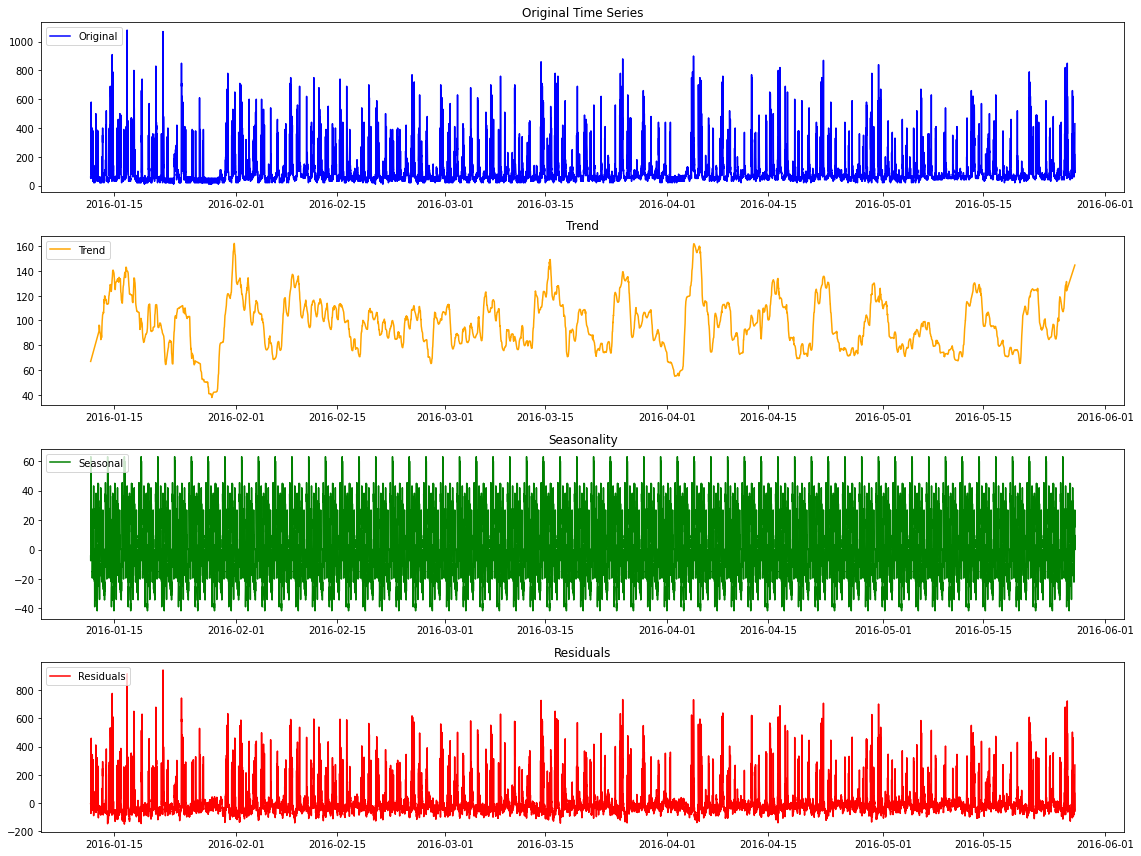

In [13]:
#seasonal decompose from statsmodel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
res=seasonal_decompose(ts_df['cnc_average_kw'], period=7*48, model='additive', extrapolate_trend='freq')

# components extractions
trend = res.trend
seasonal = res.seasonal
residual = res.resid


plt.figure(figsize=(16, 12))

# Plot Trend
plt.subplot(4, 1, 1)
plt.plot(ts_df.index, ts_df['cnc_average_kw'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot Trend
plt.subplot(4, 1, 2)
plt.plot(ts_df.index, trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend')

# Plot Seasonal
plt.subplot(4, 1, 3)
plt.plot(ts_df.index, seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonality')

# Plot Residuals
plt.subplot(4, 1, 4)
plt.plot(ts_df.index, residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.title('Residuals')


plt.tight_layout()
plt.show()
plt.show()

As we can see from the plot, the seasonal component shows a pattern. So we have to take this pattern in consideration when we will choose the predictive model, but let's proceed with the exploratory analysis:

Let's explore the correlations between all the variables with a correlation matrix:

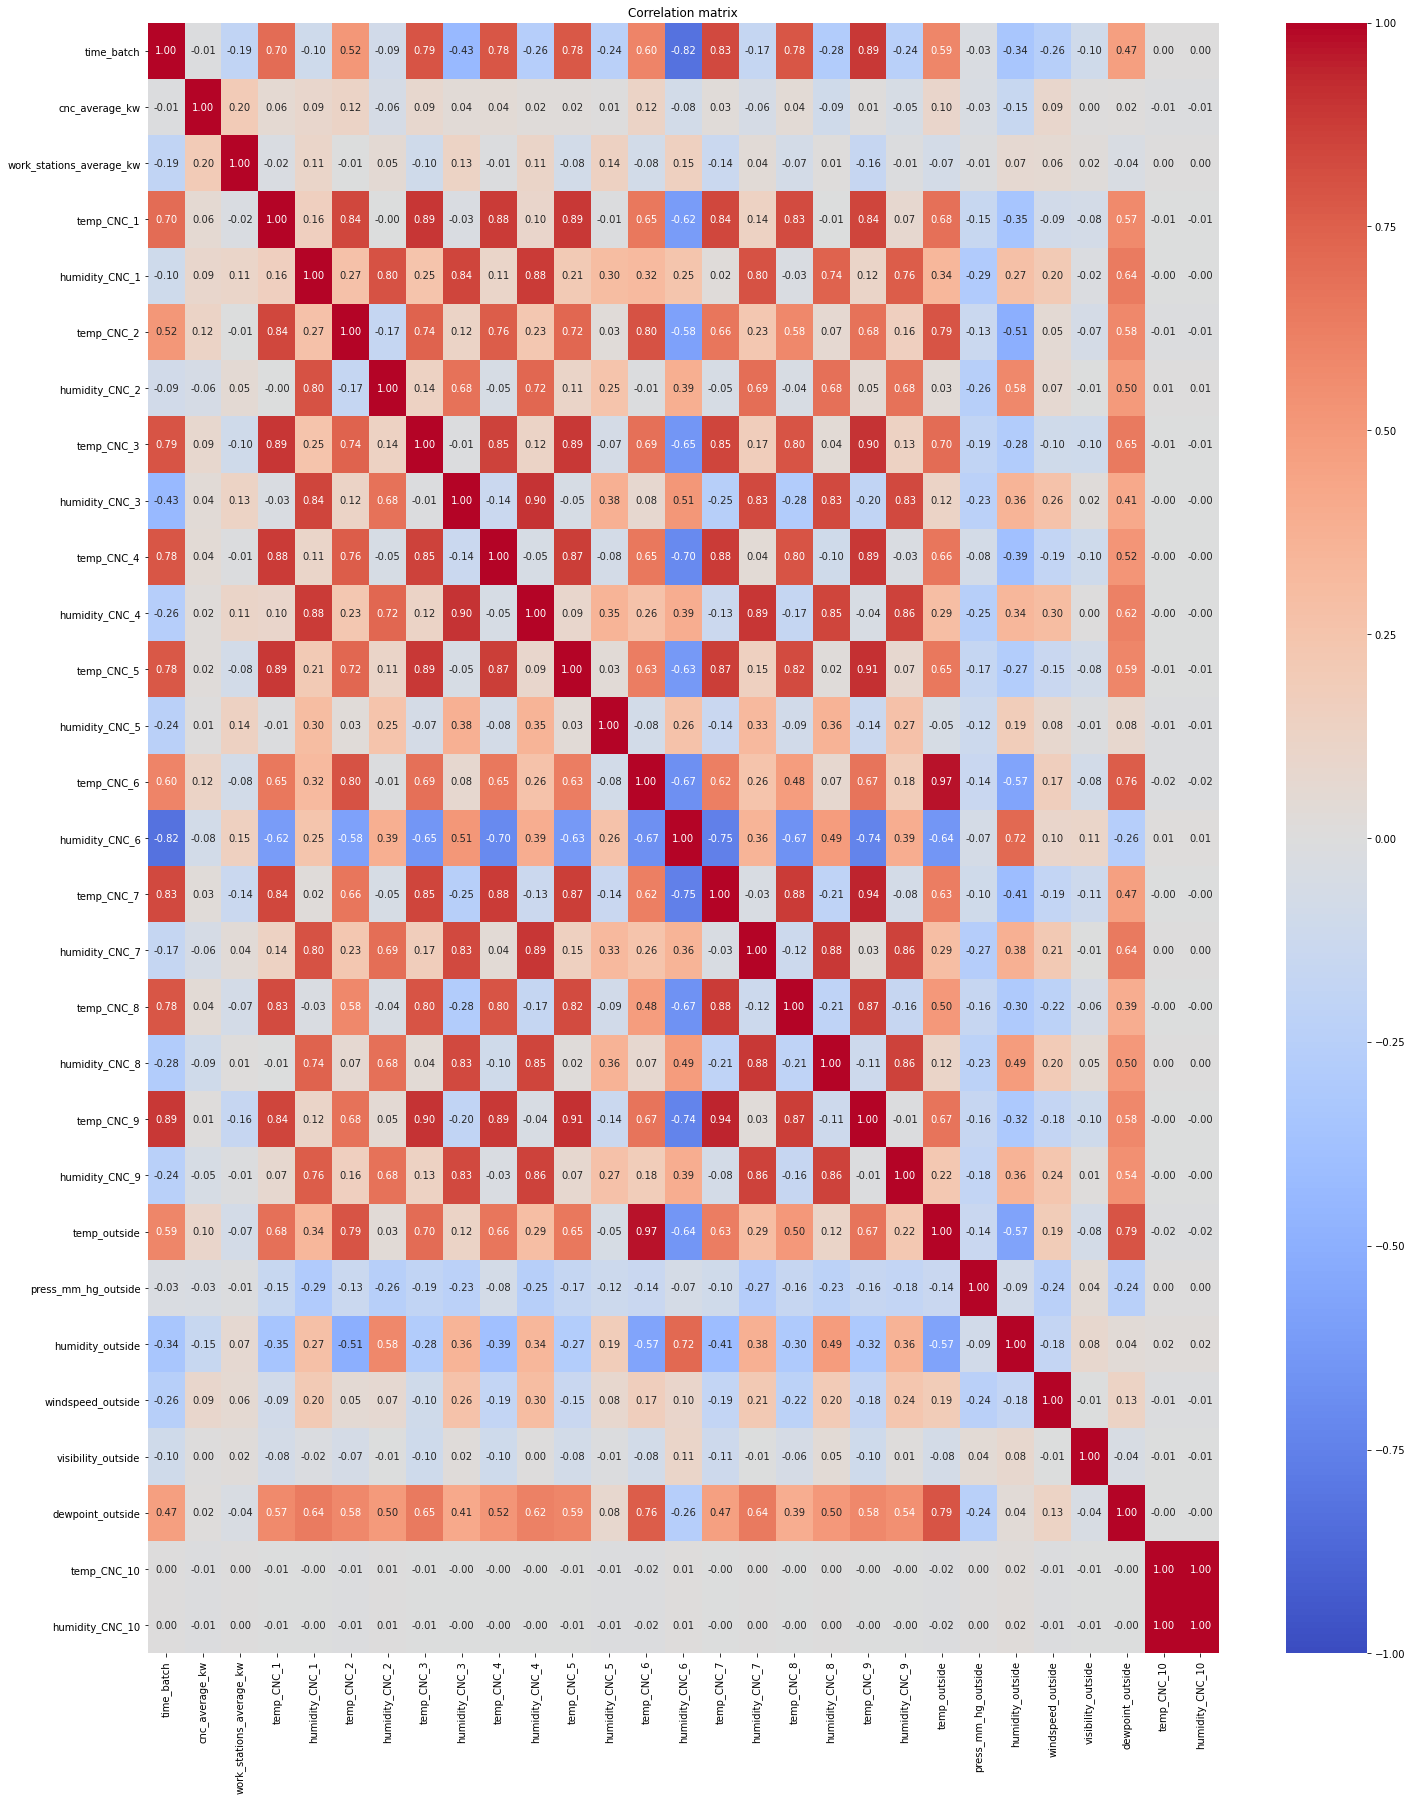

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

correlation_matrix = df.corr()

plt.figure(figsize=(24, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()


The matrix shows that there are a lot of variables that have a correlation with the others, so there is a multicollinearity issue

LINEAR REGRESSION ANALYSIS

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


y = df['cnc_average_kw']

X = df[['work_stations_average_kw', 
        'temp_CNC_1', 'temp_CNC_2', 'temp_CNC_3', 'temp_CNC_4', 'temp_CNC_5', 'temp_CNC_6', 'temp_CNC_7', 'temp_CNC_8', 'temp_CNC_9', 'temp_CNC_10', 
        'humidity_CNC_1', 'humidity_CNC_2', 'humidity_CNC_3', 'humidity_CNC_4', 'humidity_CNC_5', 'humidity_CNC_6', 'humidity_CNC_7', 'humidity_CNC_8', 'humidity_CNC_9', 'humidity_CNC_10',
        'temp_outside', 'press_mm_hg_outside', 'humidity_outside', 'windspeed_outside', 'visibility_outside', 'dewpoint_outside']]
# add intercept
X = sm.add_constant(X)

# adapting model
model = sm.OLS(y, X).fit()

# model result
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:         cnc_average_kw   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     149.7
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:33:27   Log-Likelihood:            -1.1760e+05
No. Observations:               19735   AIC:                         2.353e+05
Df Residuals:                   19708   BIC:                         2.355e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The results of the multiple regression showsvarious insights regarding the impact of independent variables (such as temperature, humidity, external conditions) on the average energy consumption of CNC machines. Here’s how to interpret the main elements of the model:

R-squared (R²):
Value: 0.165 (16.5%)
Meaning: R² indicates the percentage of variation in the dependent variable (cnc_average_kw, the average energy consumption of CNC machines) explained by the model. In this case, the model explains only 16.5% of the variation, suggesting that there are many other variables affecting energy consumption not included in this model.

Coefficient of Variables:
Meaning: Each row with a coefficient represents the impact of that variable on the average energy consumption of CNC machines, holding all other variables constant.

Interpretation:
a. work_stations_average_kw: An increase of 1 kW in the energy consumption of the workstations is associated with an increase of 1.9897 kW in CNC energy consumption. This effect is highly significant (p < 0.000).

b. temp_CNC_2: An increase of 1 unit in temperature at CNC 2 is associated with a decrease of 17.7090 kW in CNC energy consumption and is highly significant (p < 0.000).

c. temp_CNC_3: Conversely, an increase of 1 unit in temperature at CNC 3 is associated with an increase of 25.4056 kW in CNC energy consumption. This is also a very significant effect.

d. humidity_CNC_1: An increase of 1 unit in humidity near CNC 1 is associated with an increase of 15.1538 kW in average CNC energy consumption (p < 0.000).
temp_outside: An increase of 1 unit in outside temperature is associated with a decrease of 10.2212 kW in CNC consumption (p < 0.000), suggesting a possible cooling effect or better performance at higher external temperatures.

Condition Number:
Meaning: A very high condition number, as in this case, suggests the presence of multicollinearity in the model, meaning that some independent variables are highly correlated with each other, as the correlation matrix clearly shows. This can make it difficult to estimate the coefficients accurately and interpret the results. The final note confirms that there are multicollinearity issues, so maybe we have to reduce the dimensionality of the dataset or we may exclude the variables that are not significantly correlated.

Conclusions:

Not very predictive model: The low R² value (16.5%) indicates that this model explains only a small part of the variability in CNC energy consumption. There are likely other relevant variables not included in the model.
Some variables are significant: Many variables (such as workstation consumption, certain temperatures, and humidity) have a significant impact on CNC consumption. However, some others do not seem to influence consumption significantly.
So, as the multiple regression does not seem to be vary accurate, we have to calculate the importance (impact) of every variables on the CNC energy consumption by implementing a more accurate model, such as a random forest analysis:




RANDOM FOREST ANALYSIS 

In [16]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# model definition
rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = df[features[:-1]]  # tutte le features eccetto 'cnc_average_kw'
y = df['cnc_average_kw']

# model training
rf.fit(X, y)

#feature importance
importance = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# sorting features 
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature importance - Random Forest')
plt.show()


NameError: name 'features' is not defined

As we can see from this last plot and from the multiple regression analysis the most impacting variables are:

a. HUMIDITY OUTSIDE: with the increase of the humidity outside the energy consumption decrease ;

b. HUMIDITY CNC 1: with the increase of this variable, the energy consumption increase;

c. PRESS MM HG OUTSIDE: energy consumption increases when this variable increases;

d. TEMP CNC 3: the increase of this variable increases the energy consumption.


In conclusion, there are variables that are very impacting on energy consumption, but these variables are also highly correlated to each other, generating the problem of multicollinearity. This can impact on a machine learning predictive model, creating a tendency to overfitting.
Let's check if there is a tendency to overfitting with training and convalidation curves:

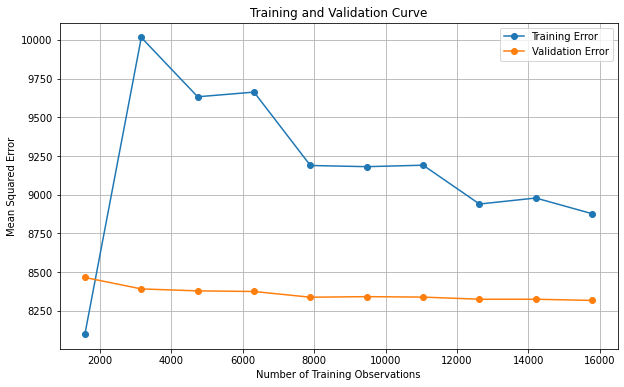

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


df['time_batch'] = (df['time_batch'] - df['time_batch'].min()).dt.days  # Converti datetime in giorni
X = df.drop(columns=['cnc_average_kw'])
y = df['cnc_average_kw']


X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model creation
model = make_pipeline(StandardScaler(), LinearRegression())

# Curve
train_errors, val_errors = [], []
train_sizes = np.linspace(0.1, 1.0, 10) * len(X_train)  # Converti in numeri di campioni

for train_size in train_sizes:
    train_size = int(train_size)
    if train_size <= 0:
        continue
    if train_size >= len(X_train):
        train_size = len(X_train) - 1

    # training subsets
    X_train_subset = X_train.iloc[:train_size]
    y_train_subset = y_train.iloc[:train_size]

    # verify the number of obs
    if len(X_train_subset) == 0 or len(y_train_subset) == 0:
        continue

    # model training
    model.fit(X_train_subset, y_train_subset)

    # forecasting and error
    y_train_pred = model.predict(X_train_subset)
    y_val_pred = model.predict(X_test)

    train_error = mean_squared_error(y_train_subset, y_train_pred)
    val_error = mean_squared_error(y_test, y_val_pred)

    train_errors.append(train_error)
    val_errors.append(val_error)

# sincronizing lenghts
valid_train_sizes = np.array([size for size, train_error, val_error in zip(train_sizes, train_errors, val_errors) if train_error is not None and val_error is not None])
valid_train_errors = [train_error for train_error in train_errors if train_error is not None]
valid_val_errors = [val_error for val_error in val_errors if val_error is not None]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(valid_train_sizes, valid_train_errors, label='Training Error', marker='o')
plt.plot(valid_train_sizes, valid_val_errors, label='Validation Error', marker='o')
plt.xlabel('Number of Training Observations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()


The plot does not shows a tendency to overfitting, as the convalidation error decrease when the number of observations increase.
So, even if from the validation and training curves there's not a overfitting tendency, the correlation matrix suggest that we may have to reduce the dimensionality of the dataet, in order to prevent overfitting.
So we can proceed reducing the dimensionality and comparing the model accuracy of the reduced dataset with the original one andthen choose the most accurate one.

3. DIMENSIONALITY REDUCTION WITH PRINCIPAL COMPONENT ANALYSIS (PCA)

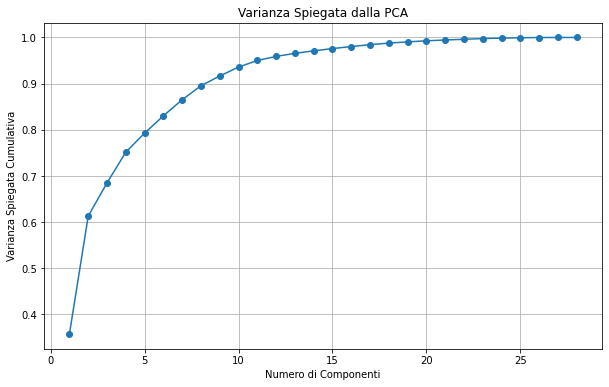

Percentuale di varianza spiegata da ciascuna componente: [3.57800256e-01 2.55470031e-01 7.18132642e-02 6.64370767e-02
 4.13704865e-02 3.73260073e-02 3.49261171e-02 3.02089938e-02
 2.12423484e-02 1.92169693e-02 1.43939551e-02 8.68715510e-03
 6.75181195e-03 5.34727020e-03 4.98363403e-03 4.30829280e-03
 4.13339754e-03 3.36121778e-03 2.60415473e-03 2.40880525e-03
 1.73527347e-03 1.56315545e-03 1.49981967e-03 1.00966419e-03
 7.61215707e-04 5.11381831e-04 1.28244830e-04 3.04875925e-33]


In [18]:
X = df.drop(columns=['cnc_average_kw'])
y = df['cnc_average_kw']


# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# explained variance for each PC
explained_variance = pca.explained_variance_ratio_

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata dalla PCA')
plt.grid(True)
plt.show()

# % OF EXPLAINED VARIANCE OF EACH COMPONENT
print(f"Percentuale di varianza spiegata da ciascuna componente: {explained_variance}")

As we can see from the plot, the first 5 components can explain the 80% of the variance, so we can reduce the 31-dim original dataset to a 5-dim reduced one.

In [19]:
#creating a new reduced dataset
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# PCA con 5 componenti principali
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# explaining var for each component
explained_variance = pca.explained_variance_ratio_

print(f"% of explained variance of each component: {explained_variance}")
print(f"cumulative explained variance: {np.cumsum(explained_variance)}")

% of explained variance of each component: [0.35780026 0.25547003 0.07181326 0.06643708 0.04137049]
cumulative explained variance: [0.35780026 0.61327029 0.68508355 0.75152063 0.79289111]


Now we will create a new reducted 5-dim dataset, in which the columns are the 5 principal components

In [20]:
features = df.drop(columns=['cnc_average_kw'])  

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA: reduce dimensionality
pca = PCA(n_components=5)
features_pca = pca.fit_transform(features_scaled)

# df with 5 PCs
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(5)])
df_pca['cnc_average_kw'] = df['cnc_average_kw']


In [21]:
df_pca

,PC1,PC2,PC3,PC4,PC5,cnc_average_kw
0,-3.666070,4.489354,1.518108,1.104954,2.272445,60
1,-3.677398,4.416562,0.996757,1.180159,2.300194,60
2,-3.708296,4.327210,0.034415,1.382531,2.331552,50
3,-3.796172,4.296825,-1.543464,1.818589,3.276376,50
4,-3.774864,4.275999,1.756169,0.833657,3.268508,60
...,...,...,...,...,...,...
19730,7.917332,3.275288,-1.447329,1.573243,-0.478813,100
19731,7.850842,3.250211,-2.036372,1.703226,-0.476015,90
19732,7.743114,3.402672,-0.143374,1.191115,0.403203,270
19733,7.625376,3.383084,1.989057,0.526184,0.373409,420


4. ASSESSING TIME-SERIES FORECASTABILITY ON THE REDUCED DATASET

In order to get strong basis to forecasting, we have first to assess the level of forecastability of the energy consumption, and we will use 3 different metrics: Moran's I, lomb_scargle_periodogram and covariance forecastability

4.1 Lomb-Scargle-Periodgram

The periodgram shows the maximum power for a determinate frequency. It represents the intensity of the periodicy in that frequency. Higher values means that a determinate frequency has a higher influence on the target variable.


In [22]:
import numpy as np
from scipy.signal import lombscargle

# Fuction to calculate Lomb-Scargle Periodogram 
def lomb_scargle_periodogram(data):
    n = len(data)
    time = np.arange(n)
    frequencies = np.linspace(0.01, 1.0, 1000)  # frequency range
    power = lombscargle(time, data, frequencies)
    return frequencies, power


X_pca = df_pca.drop(columns=['cnc_average_kw']) 

# Loop for every PC
for i in range(X_pca.shape[1]):
    data = X_pca.iloc[:, i]  
    
    # Lomb-Scargle Periodogram
    frequency, power = lomb_scargle_periodogram(data)
    print(f"Periodicity for PC{i+1}: Maximum Power={np.max(power)} at Frequency={frequency[np.argmax(power)]}")

    print("\n")

Periodicity for PC1: Maximum Power=3895.573151047394 at Frequency=0.0436936936936937


Periodicity for PC2: Maximum Power=1890.9351959780258 at Frequency=0.0436936936936937


Periodicity for PC3: Maximum Power=480.2605080973151 at Frequency=0.0436936936936937


Periodicity for PC4: Maximum Power=5202.7521949775055 at Frequency=0.0436936936936937


Periodicity for PC5: Maximum Power=1329.686310579161 at Frequency=0.0436936936936937




This result shows that the frequency at 0.0437 seems to dominate the periodic behaviour of our targe variable. This may indicate that there is a temporal pattern.
So, if our data are collected at regular intervals of 10 minutes, the frequency=0.0437 correspond to a cycle that repeat itself every 229 minutes.
Anyway, it confirm us that there is a pattern of seasonality in the enercy consumption, and we must take this into consideration for the choice of the model, as we have said before.
So in conclusion this metric suggest that the serie is highly predictable.

4.2 MORAN'S I

It measures the spatial autocorrelation

In [23]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import libpysal
from esda.moran import Moran


X_pca = df_pca.drop(columns=['cnc_average_kw'])


X_pca_array = X_pca.to_numpy()  

#temporal weight mtrix
n = X_pca_array.shape[0]
w = libpysal.weights.lat2W(n, 1)  

# I for every PC 
for i in range(X_pca_array.shape[1]):
    component = X_pca_array[:, i]  
    moran = Moran(component, w)
    print(f"Moran's I for PC{i+1}: {moran.I}")

C:\Users\User\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Moran's I for PC1: 0.9998359184706371
Moran's I for PC2: 0.9994299452108646
Moran's I for PC3: 0.07729405270836932
Moran's I for PC4: 0.9239779303422131
Moran's I for PC5: 0.8945095257404632


PC1, PC2, PC4 and PC5 shows a high spatial autocorrelation, suggesting that there are similar values in different positions, so the serie is highly predictable according to this metric.

4.3 COVARIANCE FORECASTABILITY

In [24]:
# CovF = 1 - (trace(covariance matrix) / sum(diag(covariance matrix)))

def covariance_forecastability(X):
    cov_matrix = np.cov(X, rowvar=False)
    trace_cov = np.trace(cov_matrix)
    sum_diag_cov = np.sum(np.diag(cov_matrix))
    
    if sum_diag_cov != 0:
        cov_f = 1 - (trace_cov / sum_diag_cov)
    else:
        cov_f = np.nan  # Evitiamo divisioni per zero

    return cov_f
df_pca.drop(columns=['cnc_average_kw'])

covf = covariance_forecastability(df_pca)
print(f"Covariance Forecastability (CovF): {covf}")

Covariance Forecastability (CovF): 0.0


The Covariance Forecastability equal to 0 means there is not a significative covariance between the target variable and the 5 principal components, and it can suggest that this 5 components do not capture enough useful information to have an accurate forecasting model.

CONCLUSIONS: if the question is the reliability of developing a model that can forecast the next 10 minutes, these 3 metrics shows that even if there's not a covariance, the time series is predictable because it has seasonal patterns.
In conclusion  we may try with a deep neural network like Long-Short-Term-Memory model in order to take in consideration the weight (importance) of every variable on our energy consumption.

LSTM ON REDUCTED DATASET (10 MINUTES FORECASTING)

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Function to df prep: 24 steps of  10 minuti (4h)
def create_dataset(X, y, time_steps=24):  
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])  # forecast 10 min
    return np.array(Xs), np.array(ys)

time_steps = 24  
X_lstm, y_lstm = create_dataset(X_scaled, y, time_steps)

# model def
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_lstm.shape[2])))
model.add(Dense(1))  # 10 min forecast
model.compile(optimizer='adam', loss='mean_squared_error')

#model training
model.fit(X_lstm, y_lstm, epochs=50, batch_size=32)

# forecasting
y_pred = model.predict(X_lstm)

#model evaluation
mse = mean_squared_error(y_lstm, y_pred)
print(f"Mean Squared Error: {mse}")


Epoch 1/50
616/616 [==============================] - 4s 5ms/step - loss: 11646.9395
Epoch 2/50
616/616 [==============================] - 3s 5ms/step - loss: 10022.2598
Epoch 3/50
616/616 [==============================] - 3s 5ms/step - loss: 9931.3652
Epoch 4/50
616/616 [==============================] - 3s 5ms/step - loss: 9809.4980
Epoch 5/50
616/616 [==============================] - 3s 4ms/step - loss: 9758.9873
Epoch 6/50
616/616 [==============================] - 3s 5ms/step - loss: 9650.9111
Epoch 7/50
616/616 [==============================] - 3s 5ms/step - loss: 9549.0781
Epoch 8/50
616/616 [==============================] - 3s 5ms/step - loss: 9433.5400
Epoch 9/50
616/616 [==============================] - 3s 5ms/step - loss: 9285.6650
Epoch 10/50
616/616 [==============================] - 3s 5ms/step - loss: 9121.9824
Epoch 11/50
616/616 [==============================] - 3s 5ms/step - loss: 9325.7939
Epoch 12/50
616/616 [==============================] - 3s 5ms/step - los

As we can see, the MSE of this first LSTM model is huge, so we have to try to optimize his iperparameters in order to increase its accuracy.
The best way to optimize iperparameters is by implementing a search grid that calculates every combinations of the iperparameters and chooses the best, but a Search Grid is too expensive for my computer in terms of computational cost, so we have to try changing manually the model's iperparameters:

Let's try decreasing from 50 to 30 the number of units and increasint to 100 the n of epochs:

In [26]:
# normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Function to df prep: 24 steps of  10 minuti (4h)
def create_dataset(X, y, time_steps=24):  
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])  # forecast 10 min
    return np.array(Xs), np.array(ys)

time_steps = 24  
X_lstm, y_lstm = create_dataset(X_scaled, y, time_steps)

# model def
model = Sequential()
model.add(LSTM(30, activation='relu', input_shape=(time_steps, X_lstm.shape[2])))
model.add(Dense(1))  # 10 min forecast
model.compile(optimizer='adam', loss='mean_squared_error')

#model training
model.fit(X_lstm, y_lstm, epochs=100, batch_size=32)

# forecasting
y_pred = model.predict(X_lstm)

#model evaluation
mse = mean_squared_error(y_lstm, y_pred)
print(f"Mean Squared Error: {mse}")


Epoch 1/100
616/616 [==============================] - 4s 4ms/step - loss: 11162.4678
Epoch 2/100
616/616 [==============================] - 3s 5ms/step - loss: 9940.4365
Epoch 3/100
616/616 [==============================] - 3s 5ms/step - loss: 9823.0557
Epoch 4/100
616/616 [==============================] - 3s 4ms/step - loss: 9735.0635
Epoch 5/100
616/616 [==============================] - 3s 5ms/step - loss: 9586.9053
Epoch 6/100
616/616 [==============================] - 3s 4ms/step - loss: 9571.8350
Epoch 7/100
616/616 [==============================] - 3s 4ms/step - loss: 9433.1768
Epoch 8/100
616/616 [==============================] - 3s 4ms/step - loss: 9392.9209
Epoch 9/100
616/616 [==============================] - 3s 4ms/step - loss: 9357.4102
Epoch 10/100
616/616 [==============================] - 3s 4ms/step - loss: 9252.2891
Epoch 11/100
616/616 [==============================] - 3s 4ms/step - loss: 9589.5400
Epoch 12/100
616/616 [==============================] - 3s 4ms

The MSE is decreased but is still too high for our dataset. 
The results shows us that when the number of epochs increases, the loss increases too after 76 epochs, so increasing the number of epochs does not improve the model, but instead it cause overfitting.
We can try another optimization using a tanh activation function instead of the linear one, and setting at 70 the n of epochs, as suggests the result before:

In [27]:
# normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Function to df prep: 24 steps of  10 minuti (4h)
def create_dataset(X, y, time_steps=24):  
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])  # forecast 10 min
    return np.array(Xs), np.array(ys)

time_steps = 24  
X_lstm, y_lstm = create_dataset(X_scaled, y, time_steps)

# model def
model = Sequential()
model.add(LSTM(30, activation='tanh', input_shape=(time_steps, X_lstm.shape[2])))
model.add(Dense(1))  # 10 min forecast
model.compile(optimizer='adam', loss='mean_squared_error')

#model training
model.fit(X_lstm, y_lstm, epochs=70, batch_size=32)

# forecasting
y_pred = model.predict(X_lstm)

#model evaluation
mse = mean_squared_error(y_lstm, y_pred)
print(f"Mean Squared Error: {mse}")


Epoch 1/70
616/616 [==============================] - 4s 5ms/step - loss: 17362.6543
Epoch 2/70
616/616 [==============================] - 3s 5ms/step - loss: 14562.7100
Epoch 3/70
616/616 [==============================] - 3s 4ms/step - loss: 12842.2930
Epoch 4/70
616/616 [==============================] - 3s 4ms/step - loss: 11742.6357
Epoch 5/70
616/616 [==============================] - 3s 4ms/step - loss: 11088.5342
Epoch 6/70
616/616 [==============================] - 3s 5ms/step - loss: 10740.3164
Epoch 7/70
616/616 [==============================] - 3s 5ms/step - loss: 10520.6826
Epoch 8/70
616/616 [==============================] - 3s 5ms/step - loss: 10242.5713
Epoch 9/70
616/616 [==============================] - 3s 5ms/step - loss: 9987.7236
Epoch 10/70
616/616 [==============================] - 3s 5ms/step - loss: 9786.9893
Epoch 11/70
616/616 [==============================] - 3s 5ms/step - loss: 9666.9072
Epoch 12/70
616/616 [==============================] - 3s 5ms/step

The MSE is decreased but it is still too high.
Maybe the LSTM model is not the most useful in our case, maybe because it is more effective in forecasting long time periods.
Let's try a random forest regressor:

RANDOM FOREST REGRESSOR ON REDUCTED DATASET

Mean Squared Error: 7297.284950595388


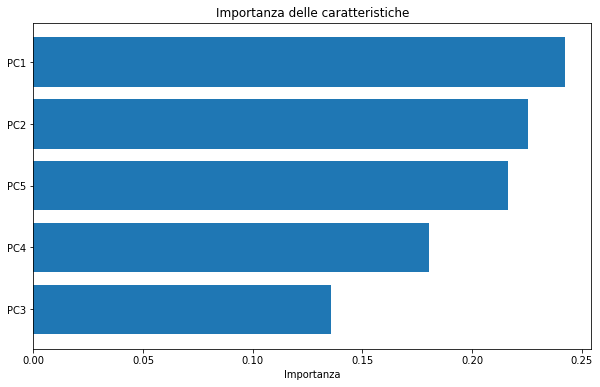

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
target = 'cnc_average_kw'  

X = df_pca[features].values
y = df_pca[target].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


import matplotlib.pyplot as plt

# FEATURE importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)


plt.figure(figsize=(10, 6))
plt.title('Importanza delle caratteristiche')
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), np.array(features)[indices])
plt.xlabel('Importanza')
plt.show()

The plot shows the impact of every Principal Component on the target variable (energy consumption).

The MSE is high again, so we have to try to optimize the model. Again, the most effective tool to optimization is a Search Grid, but I can't implement it because of its huge cost, so we can proceed with a manually empiric research: we will manipulate 2 parameters: the number of estimators and the max depth of the forest

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#variation of n_estimators e max_depth
for n_estimators in [50, 100, 200]:
    for max_depth in [10, 20, None]:
        rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, MSE: {mse}')

n_estimators: 50, max_depth: 10, MSE: 8129.253498335169
n_estimators: 50, max_depth: 20, MSE: 7449.883321834705
n_estimators: 50, max_depth: None, MSE: 7413.358003546998
n_estimators: 100, max_depth: 10, MSE: 8120.011790952461
n_estimators: 100, max_depth: 20, MSE: 7341.357953539765
n_estimators: 100, max_depth: None, MSE: 7297.284950595388
n_estimators: 200, max_depth: 10, MSE: 8083.655954051168
n_estimators: 200, max_depth: 20, MSE: 7315.285833390122
n_estimators: 200, max_depth: None, MSE: 7254.333117557638


The best combination (200 estimators and none depth) has still a high MSE (7233), so maybe the random forest regressor is not ad useful model for our dataset.


CONCLUSIONS: after trying different models and optimizing them, we still not have found a suffuciently accurate model.
So reducing the dimensionality was not useful, maybe because the PCs doen not capture enough information.
Now we proceed implementing the various models chosen before in the original  dataset:

ORIGINAL DATASET

1. ASSESSING FORECASTABILITY

1.1 Moran's I

In [30]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import libpysal
from esda.moran import Moran

X = df.drop(columns=['cnc_average_kw'])


X_array = X.to_numpy()  

#temporal w matrix
n = X_array.shape[0]
w = libpysal.weights.lat2W(n, 1)  


for i in range(X_array.shape[1]):
    component = X_array[:, i]  
    moran = Moran(component, w)
    print(f"Moran's I for variables{i+1}: {moran.I}")


Moran's I for variables1: 0.9999977823036179
Moran's I for variables2: 0.7841243850803117
Moran's I for variables3: 0.9995378167878867
Moran's I for variables4: 0.9925283145028326
Moran's I for variables5: 0.9990142540172623
Moran's I for variables6: 0.9977691313754049
Moran's I for variables7: 0.9994319580149402
Moran's I for variables8: 0.9982908081540904
Moran's I for variables9: 0.9992403622571119
Moran's I for variables10: 0.999250142313082
Moran's I for variables11: 0.9977698159366708
Moran's I for variables12: 0.9678549118878057
Moran's I for variables13: 0.9992384001926649
Moran's I for variables14: 0.9991538354568703
Moran's I for variables15: 0.9997873155072129
Moran's I for variables16: 0.999466545486556
Moran's I for variables17: 0.9996724191262281
Moran's I for variables18: 0.9991904112929344
Moran's I for variables19: 0.9997639023988683
Moran's I for variables20: 0.998970923666665
Moran's I for variables21: 0.9995576137452084
Moran's I for variables22: 0.9999587758591459


Moran's I is a measure of spatial autocorrelation, which indicates whether the spatial pattern of a variable is clustered, dispersed, or random. The values typically range from -1 (perfect dispersion) to +1 (perfect clustering), with a value near 0 indicating random spatial patterns.

Here’s an interpretation of the Moran’s I values provided:

Variables with Moran's I close to 1 (high positive autocorrelation):
Many of our variables have Moran's I values close to 1, indicating strong positive spatial autocorrelation. This suggests that similar values tend to cluster together spatially, and that is coherent with the position of the sensors. Variables like variables1, variables3, variables4, and many others have values extremely close to 1, implying that areas with high values of these variables tend to be near other areas with high values, and the same applies for low values.

Examples:

variables1: 0.99999
variables4: 0.99252
variables5: 0.99901
These indicate that the variable values are highly spatially clustered, meaning that areas or regions with similar values are adjacent.

Variables with Moran's I around 0.78-0.97 (moderate positive autocorrelation):
Variables like variables2 (0.78) and variables12 (0.96) exhibit moderate spatial autocorrelation, suggesting that there is still a tendency for similar values to cluster together, but the pattern is less strong than for the variables near 1.

Variables with Moran's I around 0 (near random spatial distribution):
For variables27 and variables28, Moran's I is around 0.0028, which is close to 0. This suggests that these variables have a random spatial distribution, meaning no significant clustering or dispersion is observed. The values of the variable at one location are not strongly influenced by values at neighboring locations.

Implications:

High values (close to 1): Strong clustering indicates that certain areas may have consistently similar environmental or operational conditions, which could point to external factors influencing energy consumption, such as localized environmental controls, shared infrastructure, or regional policies.
Moderate values (~0.78 - 0.97): Moderate clustering might suggest some spatial influence but not as strongly. Factors causing this could be weaker or more dispersed, possibly influenced by variables that fluctuate more regionally or have less direct control.
Low values (near 0): Random patterns indicate no significant spatial dependency, suggesting that factors related to these variables are more distributed independently of their spatial locations.
The extremely high values for most variables suggest that our dataset exhibits very strong spatial patterns, meaning similar values are often found in close proximity.

Lomb-Scargle Periodogram

In [31]:
import numpy as np
from scipy.signal import lombscargle


def lomb_scargle_periodogram(data):
    n = len(data)
    time = np.arange(n)
    frequencies = np.linspace(0.01, 1.0, 1000)  # Definisci un range di frequenze
    power = lombscargle(time, data, frequencies)
    return frequencies, power


X = df.drop(columns=['cnc_average_kw'])  


for i in range(X.shape[1]):
    data = X.iloc[:, i]  
    # Lomb-Scargle Periodogram
    frequency, power = lomb_scargle_periodogram(data)
    print(f"Periodicity for variables{i+1}: Maximum Power={np.max(power)} at Frequency={frequency[np.argmax(power)]}")

    print("\n")

Periodicity for variables1: Maximum Power=9325.143974472454 at Frequency=0.01


Periodicity for variables2: Maximum Power=34988.354457999594 at Frequency=0.0872972972972973


Periodicity for variables3: Maximum Power=2393.4706127415875 at Frequency=0.0436936936936937


Periodicity for variables4: Maximum Power=4126.021599776335 at Frequency=0.010990990990990991


Periodicity for variables5: Maximum Power=8154.580375316022 at Frequency=0.0436936936936937


Periodicity for variables6: Maximum Power=14100.730528577351 at Frequency=0.0436936936936937


Periodicity for variables7: Maximum Power=1806.0709396142342 at Frequency=0.01


Periodicity for variables8: Maximum Power=3548.631254454764 at Frequency=0.010990990990990991


Periodicity for variables9: Maximum Power=1516.9266125921838 at Frequency=0.01


Periodicity for variables10: Maximum Power=5056.266873959983 at Frequency=0.010990990990990991


Periodicity for variables11: Maximum Power=1065.0143132156911 at Frequency=0.01


Periodic

Maximum Power: Indicates the strength or dominance of a periodic pattern. Higher power means that the periodic signal is more prominent or pronounced for that variable.
Frequency: Indicates how often the periodic cycle repeats. A lower frequency means longer cycles, while a higher frequency means shorter, more frequent cycles.
Interpretation:
Variables with low frequency (around 0.01):

Example: Variables1, Variables7, Variables9, Variables11, Variables19, Variables22.
Frequency ≈ 0.01: These variables exhibit a longer periodic cycle, meaning the repeating pattern occurs less frequently. For example, a frequency of 0.01 might suggest a cycle that repeats every 100 time steps.
Power: The strength of these cycles varies, with Variables22 showing a particularly high maximum power (1,127,184), indicating a very strong periodic pattern at this low frequency. On the other hand, variables like Variables19 (power ≈ 1001) show weaker, but still detectable, periodicity.
Variables with moderate frequency (around 0.0437):

Example: Variables3, Variables5, Variables6, Variables13, Variables14, and many others.
Frequency ≈ 0.0437: These variables have a shorter periodic cycle than those with a frequency of 0.01. This suggests that the periodic pattern repeats more frequently, roughly every 23 time steps.
Power: Several variables in this frequency band have very strong periodic signals, such as Variables14 (power ≈ 837,993) and Variables23 (power ≈ 597,377), indicating that these cycles are particularly dominant. In contrast, Variables6 (power ≈ 14,100) shows a relatively weaker periodic pattern at the same frequency.
Variables with higher frequency (around 0.0873):

Example: Variables2, Variables12.
Frequency ≈ 0.0873: These variables have the shortest periodic cycle, meaning their patterns repeat the most frequently, approximately every 11 time steps.
Power: Variables2 (power ≈ 34,988) and Variables12 (power ≈ 34,150) both show strong periodic signals, suggesting that these short cycles are quite prominent in our data.
Special cases (e.g., Variable25 at frequency 0.0308):

Example: Variable25 has a periodic signal at a slightly different frequency (0.0308), meaning its cycle repeats every 32 time steps. The power for this periodic pattern is also strong at ≈ 17,294, indicating a noticeable cycle.

Covariance Forecastability

In [32]:
# CovF = 1 - (trace(covariance matrix) / sum(diag(covariance matrix)))

def covariance_forecastability(X):
    cov_matrix = np.cov(X, rowvar=False)
    trace_cov = np.trace(cov_matrix)
    sum_diag_cov = np.sum(np.diag(cov_matrix))
    
    if sum_diag_cov != 0:
        cov_f = 1 - (trace_cov / sum_diag_cov)
    else:
        cov_f = np.nan  # Evitiamo divisioni per zero

    return cov_f
df.drop(columns=['cnc_average_kw'])

covf = covariance_forecastability(df)
print(f"Covariance Forecastability (CovF): {covf}")

Covariance Forecastability (CovF): 0.0


CONCLUSIONS: 
the result of the two first metrics (Moran and he periodgram) shows that is possible to predict the CNC energy consumption starting from the variables in the dataset. Now we have to implement a predictive model such as LSTM to assess if the energy consumption for the next 10 minutes is predictable starting from the data of the previous 4 hours.

LSTM ON ORIGINAL DATASET (10-MINUTES FORECASTING)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


df.sort_index(inplace=True)


features = [
    'work_stations_average_kw',  
    # Temperature CNC
    'temp_CNC_1', 'temp_CNC_2', 'temp_CNC_3', 'temp_CNC_4', 'temp_CNC_5', 'temp_CNC_6', 'temp_CNC_7', 'temp_CNC_8', 'temp_CNC_9', 'temp_CNC_10',
    # Umidità CNC
    'humidity_CNC_1', 'humidity_CNC_2', 'humidity_CNC_3', 'humidity_CNC_4', 'humidity_CNC_5', 'humidity_CNC_6', 'humidity_CNC_7', 'humidity_CNC_8', 'humidity_CNC_9', 'humidity_CNC_10',
    # Condizioni esterne
    'temp_outside', 'press_mm_hg_outside', 'humidity_outside', 'windspeed_outside', 'visibility_outside', 'dewpoint_outside',
    # Target (consumo CNC)
    'cnc_average_kw'
]


data = df[features].values

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# model parameters
sequence_length = 24  #data from the last 4 hours
forecast_horizon = 1  # forecast next 10 minutes

# creating temporal seq
def create_sequences(data, sequence_length, forecast_horizon):
    sequences = []
    labels = []
    for i in range(sequence_length, len(data) - forecast_horizon):
        sequences.append(data[i-sequence_length:i, :-1])  # Usa tutte le variabili tranne il target (ultima colonna)
        labels.append(data[i + forecast_horizon - 1, -1])  # Prevedi solo 'cnc_average_kw'
    return np.array(sequences), np.array(labels)


X, y = create_sequences(scaled_data, sequence_length, forecast_horizon)


split = int(X.shape[0] * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#defining model
model = Sequential()

# 1st strate
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout per ridurre l'overfitting

# 2nd strate
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=forecast_horizon))


model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


test_loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error (MSE) on test set: {test_loss}")




Epoch 1/20
493/493 [==============================] - 15s 23ms/step - loss: 0.0102 - val_loss: 0.0070
Epoch 2/20
493/493 [==============================] - 10s 21ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 3/20
493/493 [==============================] - 10s 21ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 4/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 5/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 6/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 7/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 8/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 9/20
493/493 [==============================] - 11s 22ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 10/20
493/493 [==============================] - 11s 22ms/step - loss: 0.007

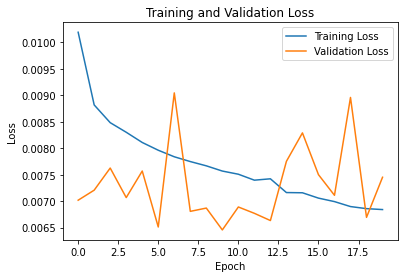

In [34]:
# Plot della perdita durante l'addestramento e la validazione
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The MSE of this model is very low, so this model is useful for the forecasting of our time series, also if the validation loss curve shows a tendency to overfitting. This tendency can bedue to the multicollinearity issues that we mentioned before. 
But let's try with random forest regressor:

RANDOM FOREST REGRESSOR ON THE ORIGINAL DATASET

In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# func to create lag features
def create_lag_features(df, target_col, lags):
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'{target_col}_lag_{lag}'] = df_lagged[target_col].shift(lag)
    return df_lagged

# add lag features for energy consumption
lags = 4 
df_lagged = create_lag_features(df, 'cnc_average_kw', lags)


df_lagged.dropna(inplace=True)


X = df_lagged.drop(columns=['cnc_average_kw'])
y = df_lagged['cnc_average_kw']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Mean Squared Error: 4112.998763617937


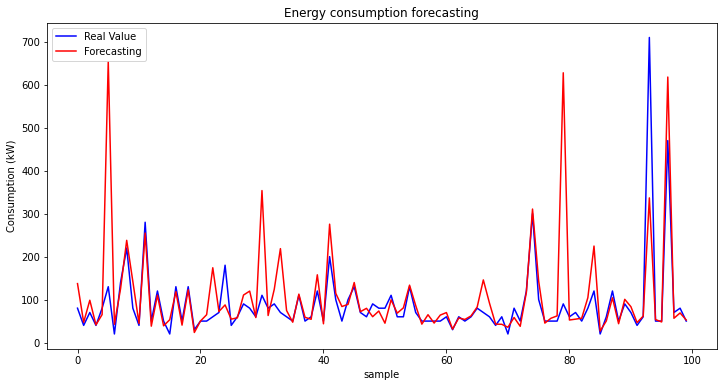

In [37]:
# prediction
y_pred = model.predict(X_test)

# evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Real Value', color='blue')
plt.plot(y_pred[:100], label='Forecasting', color='red')
plt.title('Energy consumption forecasting')
plt.xlabel('sample')
plt.ylabel('Consumption (kW)')
plt.legend()
plt.show()

As we can see the MSE is very high, so we will try to optimize it with the empirical manual research we have done before with the reduced dataset: 

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#variation of  n_estimators and max_depth
for n_estimators in [50, 100, 200]:
    for max_depth in [10, 20, None]:
        df_lagged = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        df_lagged.fit(X_train, y_train)
        y_pred = df_lagged.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, MSE: {mse}')

n_estimators: 50, max_depth: 10, MSE: 4060.6803543023484
n_estimators: 50, max_depth: 20, MSE: 4144.276874706059
n_estimators: 50, max_depth: None, MSE: 4130.725695464911
n_estimators: 100, max_depth: 10, MSE: 4069.7582120495754
n_estimators: 100, max_depth: 20, MSE: 4116.939918601982
n_estimators: 100, max_depth: None, MSE: 4112.998763617937
n_estimators: 200, max_depth: 10, MSE: 4023.9054855625054
n_estimators: 200, max_depth: 20, MSE: 4087.3409164248133
n_estimators: 200, max_depth: None, MSE: 4090.27550164682


n_estimators: 200 and  max_depth: 10 is the most accurate combination, but the MSE is still huge for our dataset.

6. CONCLUSIONS

The exploratory analysis shows the impact of every variable on the energy consumption, and the correlation matrix shaw that there are multicollinearity issues, so we reduced the original dataset into a 5-dim new dataset, in order to treat this problem. Anyway, the forecastability od the reduced dataset is lower than the one of the original  dataset. This is shown in the fact that the predictive model that we used were not enough accurate. This may be due to the fact that the 5 principal components do not capture enough information. So another step can be the one of reducing the dataset dimensionality with another technique, such as Linear Discriminant Analysis (LDA) or even a Kernel PCA.
The original dataset is more predictable than the reduced one (according to the 3 forecastability metrics), and infact the LSTM neural network model is enough accurate to forecast the next 10 minutes of energy consumption. The next step on the original dataset can be optimizing the LSTM model and try an ensemble model in order to identify a more accurate model.
So, it is possible to predict the energy consumption after 10 minutes starting from the 4-hours preceding data, and there are some very impacting variables described before (humidity outside etc) that can be manipulated in order to reduce the energy consumption.